In [1]:
! nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:03_CDT_2017
Cuda compilation tools, release 9.0, V9.0.176


In [2]:
import coco, glob, h5py, json, math, matplotlib, os, PIL, random, re, skimage, sys, time, torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.utils.data

from azure.storage import CloudStorageAccount
from azure.storage.blob import BlockBlobService
from PIL import Image, ImageOps
from skimage import draw
from torch.autograd import Variable
from torchvision import datasets

# Import Mask R-CNN
TOP_DIR = os.path.abspath("../")
sys.path.append(TOP_DIR)
import utils, visualize
import model as modellib

from config import Config
from model import log

from tensorboardX import SummaryWriter

/anaconda/envs/E3Hack-SvB/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
%matplotlib inline

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
%run AzureStorageHelper.ipynb

In [6]:
# Root directory of the project
TOP_DIR = os.path.abspath("../")

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory of images to run detection on
DATA_DIR = os.path.join(ROOT_DIR, 'frames')

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')

COCO_MODEL_PATH = os.path.join(ROOT_DIR, 'mask_rcnn_coco.pth')

### Notebook Preferences

In [7]:
def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

### Select Training Set

In [8]:
dataset = '201807250642'
test_dataset = 'test'

### Download Training Set

In [9]:
download_files(model_training_share, os.path.join(dataset, 'train'), download_path='./frames/train')
download_files(model_training_share, os.path.join(dataset, 'validate'), download_path='./frames/validate')
download_files(model_training_share, test_dataset, download_path='./frames/test')

###  Dataset Class

This is a custom class extending the `Dataset` class in `utils.py`.  This specifically deals with the annotations exported as json polygons from the VGG Image Annotator.  Note, a mask is the space within the polygon representing the shape and area of the object.

In [10]:
class CustomDataset(utils.Dataset):

    def load_frames(self, class_names, dataset_path, subset, region_data_json):
        for class_name in class_names:
            self.add_class("custom", class_name, str(class_name))

        assert subset in ["train", "validate"]

        annotations = json.load(open(os.path.join(dataset_path, region_data_json)))
        annotations = list(annotations.values()) # don't need the dict keys
        
        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [annotation for annotation in annotations if annotation['regions']]
        
        print('Images: ', len(annotations))
        
        # Add images
        for annotation in annotations:
            image_path = os.path.join(dataset_path, subset, annotation['filename'])
            
            not_missing = os.path.isfile(image_path)
            
            if not_missing:
                # Get the x, y coordinaets of points of the polygons that make up
                # the outline of each object instance. There are stores in the
                # shape_attributes (see json format above)
                polygons = [region['shape_attributes'] for region in annotation['regions'].values()]

                # load_mask() needs the image size to convert polygons to masks.
                # Unfortunately, VIA doesn't include it in JSON, so we must read
                # the image. This is only managable since the dataset is tiny.
                image = skimage.io.imread(image_path)
                height, width = image.shape[:2]

                self.add_image(
                    "custom",
                    image_id=annotation['filename'],  # use file name as a unique image id
                    path=image_path,
                    height=height,
                    width=width,
                    polygons=polygons)
            else:
                print(annotation['filename'] + ' missing')

    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        
        if image_info["source"] != "custom":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape [height, width, instance_count]
        info = self.image_info[image_id]
        
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])], dtype=np.uint8)
        
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class Ids of each instance
        return mask, np.ones([mask.shape[-1]], dtype=np.int32) # TODO: Return class Ids instead of np.ones...

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "custom":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

### Initialize Training and Validation Datasets

For the images there are two sub folders inside the images (`frames`) directory: `train` and `validate`.  These two subfolders have the images which correspond to labels (polygons here) contained in JSON - the output of the VGG Annotator Tool (http://www.robots.ox.ac.uk/~vgg/software/via/via.html).

In [11]:
class_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

print('Training Set')
dataset_path = './frames'
subset = 'train'
json_path = os.path.join(subset, 'via_region_data_{0}.json'.format(subset))

dataset_train = CustomDataset()
dataset_train.load_frames(class_names, dataset_path, subset, json_path)
dataset_train.prepare()

print('Validation Set')
dataset_path = './frames'
subset = 'validate'
json_path = os.path.join(subset, 'via_region_data_{0}.json'.format(subset))

dataset_validate = CustomDataset()
dataset_validate.load_frames(class_names, dataset_path, subset, json_path)
dataset_validate.prepare()

Training Set
Images:  538
vlcsnap-1690-09-12-04h54m06s317.png missing
vlcsnap-4673-06-21-02h48m51s239.png missing
vlcsnap-4248-07-01-00h18m41s811.png missing
vlcsnap-0367-01-30-04h01m00s600.png missing
vlcsnap-1403-09-05-16h58m25s195.png missing
vlcsnap-9261-12-15-06h05m18s453.png missing
vlcsnap-2228-08-20-09h07m19s635.png missing
vlcsnap-8611-06-18-09h06m46s716.png missing
vlcsnap-5224-10-26-15h35m50s816.png missing
vlcsnap-5242-05-01-05h32m36s447.png missing
vlcsnap-4230-01-04-13h03m32s022.png missing
vlcsnap-6727-11-03-04h33m19s098.png missing
vlcsnap-1272-12-25-12h02m16s665.png missing
vlcsnap-0931-10-08-06h05m09s587.png missing
vlcsnap-5222-08-06-08h18m12s092.png missing
vlcsnap-6696-11-03-06h11m36s073.png missing
vlcsnap-6357-02-07-10h11m38s707.png missing
vlcsnap-3881-12-20-05h47m40s297.png missing
vlcsnap-1611-03-08-13h20m43s609.png missing
vlcsnap-6015-09-13-14h22m57s277.png missing
vlcsnap-0108-09-15-07h38m29s248.png missing
vlcsnap-6311-11-18-05h41m25s275.png missing
vlcsna

### Configuration

In [12]:
print('torch.cuda.is_available', torch.cuda.is_available())
if torch.cuda.is_available():
    print('torch.cuda.current_device: ', torch.cuda.current_device())
    print('torch.cuda.device_count: ', torch.cuda.device_count())
    for index in range(torch.cuda.device_count()):
        print('torch.cuda.device: (%d)' % index, torch.cuda.device(index))
        print('torch.cuda.get_device_name: (%d)' % index, torch.cuda.get_device_name(index))

torch.cuda.is_available True
torch.cuda.current_device:  0
torch.cuda.device_count:  1
torch.cuda.device: (0) <torch.cuda.device object at 0x7f2e82649320>
torch.cuda.get_device_name: (0) Tesla K80


In [13]:
class ModelConfig(Config):
    # GPU_COUNT * IMAGES_PER_GPU
    BATCH_SIZE = 2
    
    COCO_MODEL_PATH = COCO_MODEL_PATH
    
    DETECTION_MIN_CONFIDENCE = 0.70
    
    GPU_COUNT = 1
    
    IMAGES_PER_GPU = 2
    
    IMAGE_MAX_DIM = 1920
    
    LEARNING_RATE = 0.001
    
    NAME = "custom"

    # Number of classes (including background)
    NUM_CLASSES = 10 + 1
    
    # Necessary for docker image to optimize memory usage best
    NUM_WORKERS = 0
    
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 5
    
    VALIDATION_STEPS = 5
    
# Configurations
config = ModelConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[480 480]
 [240 240]
 [120 120]
 [ 60  60]
 [ 30  30]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COCO_MODEL_PATH                /home/e3hackdsvm/notebooks/Machine-Learning-Containers/ModelTraining_GPU/mask_rcnn_coco.pth
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGENET_MODEL_PATH            /home/e3hackdsvm/notebooks/Machine-Learning-Containers/ModelTraining_GPU/resnet50_imagenet.pth
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1920
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1920 1920    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIX

### Check Disk Space

In [14]:
!df -h

Filesystem                                                     Size  Used Avail Use% Mounted on
udev                                                            28G     0   28G   0% /dev
tmpfs                                                          5.6G  105M  5.5G   2% /run
/dev/sda1                                                       49G   45G  4.1G  92% /
tmpfs                                                           28G   43M   28G   1% /dev/shm
tmpfs                                                          5.0M     0  5.0M   0% /run/lock
tmpfs                                                           28G     0   28G   0% /sys/fs/cgroup
/dev/sdc1                                                       99G   46G   48G  49% /data
/dev/sdb1                                                      335G   67M  318G   1% /mnt
tmpfs                                                          5.6G   48K  5.6G   1% /run/user/1003
//ntfisheriesstoreeastdev.file.core.windows.net/modeltraining  5.0T

### Create and Train Model

For a quick summary the model architecture consists of the following modules:

* Backbone

  * Resnet CNN as a featurizer
  * Feature Pyramid Network - refines the features to better represent objects at multiple scales.
  
  
* Region Proposal Network - scans and finds areas that contain objects

  * Output:
    * Anchor class
    * Bounding box refinement
    
    
* Region of Interest Classifier (using ROI Align for ROI pooling) and Bounding Box Regressor

  * Output
    * Class (Background, BG, included)
    * Bounding box refinement (further refinement)
    
    
* Segmentation Mask Network (CNN)

  * Output:  "soft" masks (floating point numbers instead of binary mask for comparison)
  
  
Train in two stages:

1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers='all'` to train all layers.

In [21]:
%%time

writer = SummaryWriter('./runs')

model = modellib.MaskRCNN(config=config, model_dir=MODEL_DIR, writer=writer)

if config.GPU_COUNT > 0:
    print('Cuda!', config.GPU_COUNT)
    model = model.cuda()

pretrained_state = torch.load(COCO_MODEL_PATH)
model_state = model.state_dict()

pretrained_state = { k:v for k,v in pretrained_state.items() if k in model_state and v.size() == model_state[k].size() }
model_state.update(pretrained_state)
model.load_state_dict(model_state)

stages = [('heads', 10, config.LEARNING_RATE), ('4+', 20, config.LEARNING_RATE), ('all', 30, config.LEARNING_RATE / 10)]

for stage in stages:   
    print('Training layer {0} to {1} epochs at learning rate {2}'.format(stage[0], stage[1], stage[2]))
    model.train_model(dataset_train,
                      dataset_validate,
                      learning_rate=stage[2],
                      epochs=stage[1],
                      layers=stage[0])

Cuda! 1
Training layer heads to 10 epochs at learning rate 0.001

Starting at epoch 1. LR=0.001

Checkpoint Path: /home/e3hackdsvm/notebooks/Machine-Learning-Containers/ModelTraining_GPU/logs/custom20180802T0756/mask_rcnn_custom_{:04d}.pth
Epoch 1/10.
torch.Size([])
	1/10 |█---------| 10.0% Complete - loss: 6.47112 - rpn_class_loss: 0.12643 - rpn_bbox_loss: 1.71957 - mrcnn_class_loss: 2.82289 - mrcnn_bbox_loss: 0.79899 - mrcnn_mask_loss: 1.00323
torch.Size([])
	2/10 |██--------| 20.0% Complete - loss: 4.65204 - rpn_class_loss: 0.00851 - rpn_bbox_loss: 0.06080 - mrcnn_class_loss: 2.73190 - mrcnn_bbox_loss: 0.58343 - mrcnn_mask_loss: 1.26739
torch.Size([])
	3/10 |███-------| 30.0% Complete - loss: 4.55758 - rpn_class_loss: 0.06960 - rpn_bbox_loss: 0.29104 - mrcnn_class_loss: 2.66427 - mrcnn_bbox_loss: 0.63813 - mrcnn_mask_loss: 0.89454
torch.Size([])
	4/10 |████------| 40.0% Complete - loss: 4.60932 - rpn_class_loss: 0.05841 - rpn_bbox_loss: 0.76085 - mrcnn_class_loss: 2.63111 - mrcnn_bb

torch.Size([])
	1/5 |██--------| 20.0% Complete - loss: 1.88910 - rpn_class_loss: 0.03502 - rpn_bbox_loss: 0.32898 - mrcnn_class_loss: 0.43500 - mrcnn_bbox_loss: 0.68835 - mrcnn_mask_loss: 0.40175
torch.Size([])
	2/5 |████------| 40.0% Complete - loss: 1.61670 - rpn_class_loss: 0.00756 - rpn_bbox_loss: 0.27085 - mrcnn_class_loss: 0.26934 - mrcnn_bbox_loss: 0.69033 - mrcnn_mask_loss: 0.37863
torch.Size([])
	3/5 |██████----| 60.0% Complete - loss: 1.71121 - rpn_class_loss: 0.00071 - rpn_bbox_loss: 0.46999 - mrcnn_class_loss: 0.22110 - mrcnn_bbox_loss: 0.65933 - mrcnn_mask_loss: 0.36008
torch.Size([])
	4/5 |████████--| 80.0% Complete - loss: 1.93726 - rpn_class_loss: 0.11460 - rpn_bbox_loss: 0.36732 - mrcnn_class_loss: 0.37517 - mrcnn_bbox_loss: 0.69636 - mrcnn_mask_loss: 0.38381
torch.Size([])
	5/5 |██████████| 100.0% Complete - loss: 1.87616 - rpn_class_loss: 0.07080 - rpn_bbox_loss: 0.45688 - mrcnn_class_loss: 0.41616 - mrcnn_bbox_loss: 0.58534 - mrcnn_mask_loss: 0.34698

Epoch 4/10.
t

torch.Size([])
	8/10 |████████--| 80.0% Complete - loss: 1.25104 - rpn_class_loss: 0.00225 - rpn_bbox_loss: 0.27189 - mrcnn_class_loss: 0.28398 - mrcnn_bbox_loss: 0.47762 - mrcnn_mask_loss: 0.21530
torch.Size([])
	9/10 |█████████-| 90.0% Complete - loss: 2.08476 - rpn_class_loss: 0.26309 - rpn_bbox_loss: 0.40701 - mrcnn_class_loss: 0.48932 - mrcnn_bbox_loss: 0.51821 - mrcnn_mask_loss: 0.40714
torch.Size([])
	10/10 |██████████| 100.0% Complete - loss: 2.42662 - rpn_class_loss: 0.09790 - rpn_bbox_loss: 0.51754 - mrcnn_class_loss: 0.54296 - mrcnn_bbox_loss: 0.76405 - mrcnn_mask_loss: 0.50416

torch.Size([])
	1/5 |██--------| 20.0% Complete - loss: 1.78294 - rpn_class_loss: 0.12527 - rpn_bbox_loss: 0.56018 - mrcnn_class_loss: 0.30417 - mrcnn_bbox_loss: 0.42311 - mrcnn_mask_loss: 0.37022
torch.Size([])
	2/5 |████------| 40.0% Complete - loss: 1.36131 - rpn_class_loss: 0.00489 - rpn_bbox_loss: 0.19392 - mrcnn_class_loss: 0.34862 - mrcnn_bbox_loss: 0.44941 - mrcnn_mask_loss: 0.36447
torch.Siz

torch.Size([])
	5/10 |█████-----| 50.0% Complete - loss: 2.18003 - rpn_class_loss: 0.00982 - rpn_bbox_loss: 0.58015 - mrcnn_class_loss: 0.49148 - mrcnn_bbox_loss: 0.59597 - mrcnn_mask_loss: 0.50261
torch.Size([])
	6/10 |██████----| 60.0% Complete - loss: 1.86235 - rpn_class_loss: 0.00199 - rpn_bbox_loss: 0.38274 - mrcnn_class_loss: 0.39771 - mrcnn_bbox_loss: 0.70362 - mrcnn_mask_loss: 0.37629
torch.Size([])
	7/10 |███████---| 70.0% Complete - loss: 2.81073 - rpn_class_loss: 0.00604 - rpn_bbox_loss: 1.01520 - mrcnn_class_loss: 0.65785 - mrcnn_bbox_loss: 0.67944 - mrcnn_mask_loss: 0.45221
torch.Size([])
	8/10 |████████--| 80.0% Complete - loss: 2.35249 - rpn_class_loss: 0.07274 - rpn_bbox_loss: 2.27976 - mrcnn_class_loss: 0.00000 - mrcnn_bbox_loss: 0.00000 - mrcnn_mask_loss: 0.00000
torch.Size([])
	9/10 |█████████-| 90.0% Complete - loss: 2.87823 - rpn_class_loss: 0.02824 - rpn_bbox_loss: 0.24455 - mrcnn_class_loss: 1.03299 - mrcnn_bbox_loss: 0.73024 - mrcnn_mask_loss: 0.84222
torch.Size

Epoch 12/20.
torch.Size([])
	1/10 |█---------| 10.0% Complete - loss: 2.10217 - rpn_class_loss: 0.02137 - rpn_bbox_loss: 0.33351 - mrcnn_class_loss: 0.49799 - mrcnn_bbox_loss: 0.72042 - mrcnn_mask_loss: 0.52887
torch.Size([])
	2/10 |██--------| 20.0% Complete - loss: 2.18895 - rpn_class_loss: 0.01707 - rpn_bbox_loss: 0.19594 - mrcnn_class_loss: 0.68891 - mrcnn_bbox_loss: 0.60219 - mrcnn_mask_loss: 0.68485
torch.Size([])
	3/10 |███-------| 30.0% Complete - loss: 3.21572 - rpn_class_loss: 0.02480 - rpn_bbox_loss: 1.19713 - mrcnn_class_loss: 0.81470 - mrcnn_bbox_loss: 0.66895 - mrcnn_mask_loss: 0.51013
torch.Size([])
	4/10 |████------| 40.0% Complete - loss: 3.28888 - rpn_class_loss: 0.00763 - rpn_bbox_loss: 2.23569 - mrcnn_class_loss: 0.17904 - mrcnn_bbox_loss: 0.50667 - mrcnn_mask_loss: 0.35984
torch.Size([])
	5/10 |█████-----| 50.0% Complete - loss: 1.21980 - rpn_class_loss: 0.00190 - rpn_bbox_loss: 0.53845 - mrcnn_class_loss: 0.12527 - mrcnn_bbox_loss: 0.30550 - mrcnn_mask_loss: 0.248

torch.Size([])
	3/5 |██████----| 60.0% Complete - loss: 0.48951 - rpn_class_loss: 0.00929 - rpn_bbox_loss: 0.04661 - mrcnn_class_loss: 0.06182 - mrcnn_bbox_loss: 0.19123 - mrcnn_mask_loss: 0.18056
torch.Size([])
	4/5 |████████--| 80.0% Complete - loss: 1.32683 - rpn_class_loss: 0.00434 - rpn_bbox_loss: 0.24934 - mrcnn_class_loss: 0.30980 - mrcnn_bbox_loss: 0.39376 - mrcnn_mask_loss: 0.36958
torch.Size([])
	5/5 |██████████| 100.0% Complete - loss: 1.36522 - rpn_class_loss: 0.01192 - rpn_bbox_loss: 0.37161 - mrcnn_class_loss: 0.23233 - mrcnn_bbox_loss: 0.46742 - mrcnn_mask_loss: 0.28194

Epoch 15/20.
torch.Size([])
	1/10 |█---------| 10.0% Complete - loss: 1.72026 - rpn_class_loss: 0.01215 - rpn_bbox_loss: 0.15750 - mrcnn_class_loss: 0.53296 - mrcnn_bbox_loss: 0.69528 - mrcnn_mask_loss: 0.32237
torch.Size([])
	2/10 |██--------| 20.0% Complete - loss: 1.50707 - rpn_class_loss: 0.02291 - rpn_bbox_loss: 0.32229 - mrcnn_class_loss: 0.33761 - mrcnn_bbox_loss: 0.56499 - mrcnn_mask_loss: 0.2592

torch.Size([])
	10/10 |██████████| 100.0% Complete - loss: 0.93838 - rpn_class_loss: 0.00747 - rpn_bbox_loss: 0.17337 - mrcnn_class_loss: 0.19357 - mrcnn_bbox_loss: 0.30833 - mrcnn_mask_loss: 0.25563

torch.Size([])
	1/5 |██--------| 20.0% Complete - loss: 2.38332 - rpn_class_loss: 0.01775 - rpn_bbox_loss: 0.40535 - mrcnn_class_loss: 0.74759 - mrcnn_bbox_loss: 0.74872 - mrcnn_mask_loss: 0.46391
torch.Size([])
	2/5 |████------| 40.0% Complete - loss: 1.70648 - rpn_class_loss: 0.00938 - rpn_bbox_loss: 0.24965 - mrcnn_class_loss: 0.44743 - mrcnn_bbox_loss: 0.71467 - mrcnn_mask_loss: 0.28536
torch.Size([])
	3/5 |██████----| 60.0% Complete - loss: 1.16803 - rpn_class_loss: 0.00245 - rpn_bbox_loss: 0.15407 - mrcnn_class_loss: 0.43383 - mrcnn_bbox_loss: 0.28214 - mrcnn_mask_loss: 0.29554
torch.Size([])
	4/5 |████████--| 80.0% Complete - loss: 0.69058 - rpn_class_loss: 0.01016 - rpn_bbox_loss: 0.06702 - mrcnn_class_loss: 0.13552 - mrcnn_bbox_loss: 0.22824 - mrcnn_mask_loss: 0.24963
torch.Size(

torch.Size([])
	7/10 |███████---| 70.0% Complete - loss: 1.41611 - rpn_class_loss: 0.02127 - rpn_bbox_loss: 0.34692 - mrcnn_class_loss: 0.32379 - mrcnn_bbox_loss: 0.44987 - mrcnn_mask_loss: 0.27426
torch.Size([])
	8/10 |████████--| 80.0% Complete - loss: 1.08640 - rpn_class_loss: 0.01455 - rpn_bbox_loss: 0.10526 - mrcnn_class_loss: 0.25464 - mrcnn_bbox_loss: 0.39581 - mrcnn_mask_loss: 0.31614
torch.Size([])
	9/10 |█████████-| 90.0% Complete - loss: 0.78843 - rpn_class_loss: 0.00198 - rpn_bbox_loss: 0.09852 - mrcnn_class_loss: 0.13172 - mrcnn_bbox_loss: 0.29248 - mrcnn_mask_loss: 0.26372
torch.Size([])
	10/10 |██████████| 100.0% Complete - loss: 0.65712 - rpn_class_loss: 0.00997 - rpn_bbox_loss: 0.14705 - mrcnn_class_loss: 0.17819 - mrcnn_bbox_loss: 0.11892 - mrcnn_mask_loss: 0.20299

torch.Size([])
	1/5 |██--------| 20.0% Complete - loss: 1.06948 - rpn_class_loss: 0.02596 - rpn_bbox_loss: 0.12605 - mrcnn_class_loss: 0.32400 - mrcnn_bbox_loss: 0.38077 - mrcnn_mask_loss: 0.21270
torch.Si

torch.Size([])
	2/10 |██--------| 20.0% Complete - loss: 1.76236 - rpn_class_loss: 0.00781 - rpn_bbox_loss: 0.33797 - mrcnn_class_loss: 0.34079 - mrcnn_bbox_loss: 0.81189 - mrcnn_mask_loss: 0.26391
torch.Size([])
	3/10 |███-------| 30.0% Complete - loss: 1.34421 - rpn_class_loss: 0.00662 - rpn_bbox_loss: 0.25580 - mrcnn_class_loss: 0.42066 - mrcnn_bbox_loss: 0.42648 - mrcnn_mask_loss: 0.23464
torch.Size([])
	4/10 |████------| 40.0% Complete - loss: 0.81462 - rpn_class_loss: 0.01694 - rpn_bbox_loss: 0.11436 - mrcnn_class_loss: 0.22116 - mrcnn_bbox_loss: 0.24586 - mrcnn_mask_loss: 0.21631
torch.Size([])
	5/10 |█████-----| 50.0% Complete - loss: 0.53174 - rpn_class_loss: 0.00356 - rpn_bbox_loss: 0.10978 - mrcnn_class_loss: 0.10977 - mrcnn_bbox_loss: 0.14178 - mrcnn_mask_loss: 0.16685
torch.Size([])
	6/10 |██████----| 60.0% Complete - loss: 1.44414 - rpn_class_loss: 0.01340 - rpn_bbox_loss: 0.80125 - mrcnn_class_loss: 0.12334 - mrcnn_bbox_loss: 0.20447 - mrcnn_mask_loss: 0.30167
torch.Size

torch.Size([])
	4/5 |████████--| 80.0% Complete - loss: 0.95535 - rpn_class_loss: 0.00610 - rpn_bbox_loss: 0.12794 - mrcnn_class_loss: 0.37753 - mrcnn_bbox_loss: 0.22041 - mrcnn_mask_loss: 0.22337
torch.Size([])
	5/5 |██████████| 100.0% Complete - loss: 1.43910 - rpn_class_loss: 0.00885 - rpn_bbox_loss: 0.19431 - mrcnn_class_loss: 0.44631 - mrcnn_bbox_loss: 0.53027 - mrcnn_mask_loss: 0.25935

Epoch 26/30.
torch.Size([])
	1/10 |█---------| 10.0% Complete - loss: 0.98491 - rpn_class_loss: 0.00794 - rpn_bbox_loss: 0.09735 - mrcnn_class_loss: 0.29716 - mrcnn_bbox_loss: 0.31489 - mrcnn_mask_loss: 0.26756
torch.Size([])
	2/10 |██--------| 20.0% Complete - loss: 2.98080 - rpn_class_loss: 0.01394 - rpn_bbox_loss: 0.53801 - mrcnn_class_loss: 0.85854 - mrcnn_bbox_loss: 0.88131 - mrcnn_mask_loss: 0.68901
torch.Size([])
	3/10 |███-------| 30.0% Complete - loss: 2.61981 - rpn_class_loss: 0.01431 - rpn_bbox_loss: 0.80661 - mrcnn_class_loss: 0.91240 - mrcnn_bbox_loss: 0.31727 - mrcnn_mask_loss: 0.569

torch.Size([])
	1/5 |██--------| 20.0% Complete - loss: 2.62061 - rpn_class_loss: 0.00403 - rpn_bbox_loss: 0.61810 - mrcnn_class_loss: 0.59767 - mrcnn_bbox_loss: 0.90838 - mrcnn_mask_loss: 0.49242
torch.Size([])
	2/5 |████------| 40.0% Complete - loss: 1.22146 - rpn_class_loss: 0.01301 - rpn_bbox_loss: 0.07529 - mrcnn_class_loss: 0.42523 - mrcnn_bbox_loss: 0.34670 - mrcnn_mask_loss: 0.36124
torch.Size([])
	3/5 |██████----| 60.0% Complete - loss: 0.71039 - rpn_class_loss: 0.00776 - rpn_bbox_loss: 0.10508 - mrcnn_class_loss: 0.15865 - mrcnn_bbox_loss: 0.21597 - mrcnn_mask_loss: 0.22293
torch.Size([])
	4/5 |████████--| 80.0% Complete - loss: 1.35613 - rpn_class_loss: 0.00928 - rpn_bbox_loss: 0.29540 - mrcnn_class_loss: 0.40368 - mrcnn_bbox_loss: 0.34597 - mrcnn_mask_loss: 0.30180
torch.Size([])
	5/5 |██████████| 100.0% Complete - loss: 0.82363 - rpn_class_loss: 0.00839 - rpn_bbox_loss: 0.11017 - mrcnn_class_loss: 0.29939 - mrcnn_bbox_loss: 0.18841 - mrcnn_mask_loss: 0.21727

Epoch 29/30.


### Score using Test Set

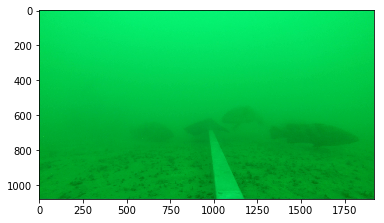

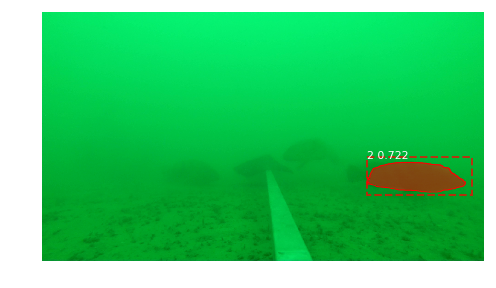

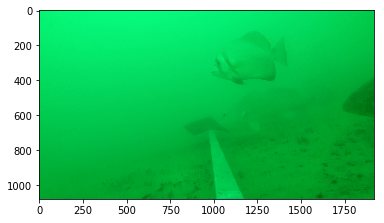

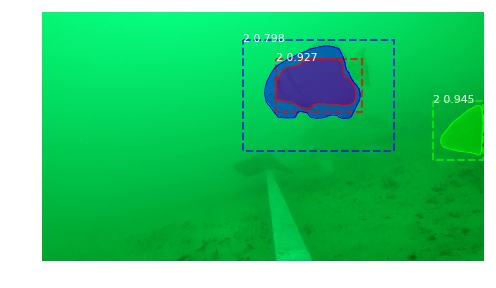

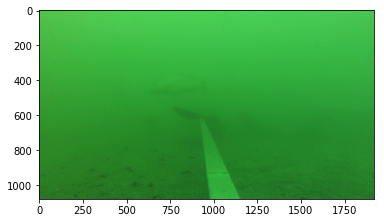

trying to index 2 dimensions of a 0 dimensional tensor


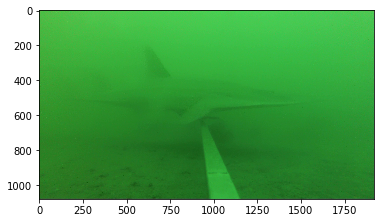

trying to index 2 dimensions of a 0 dimensional tensor


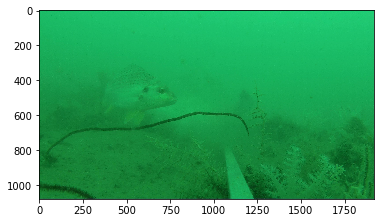

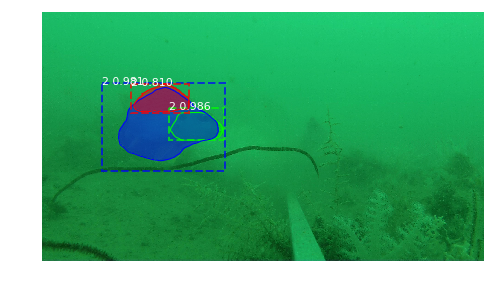

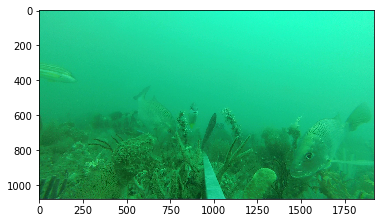

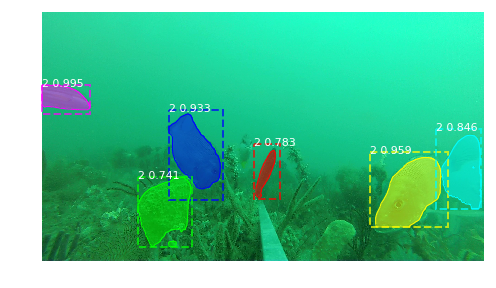

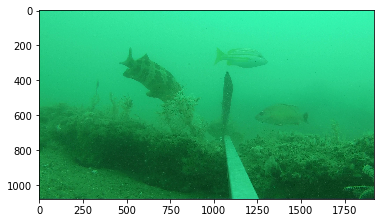

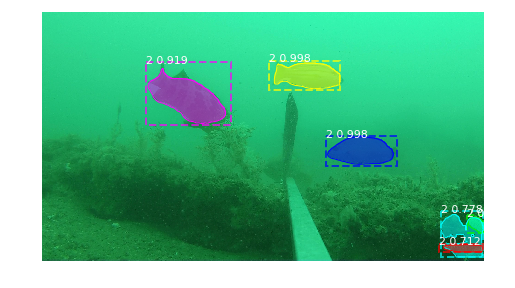

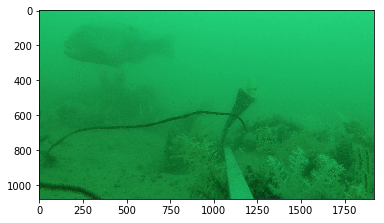

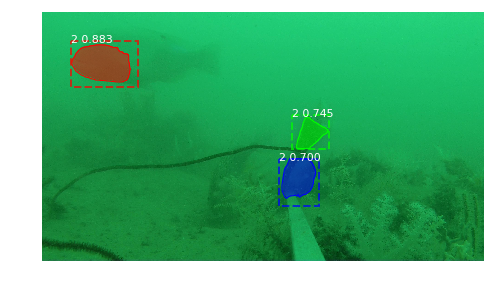

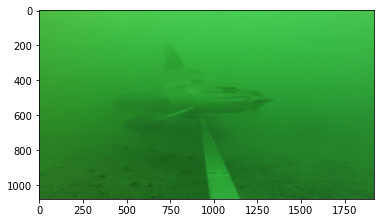

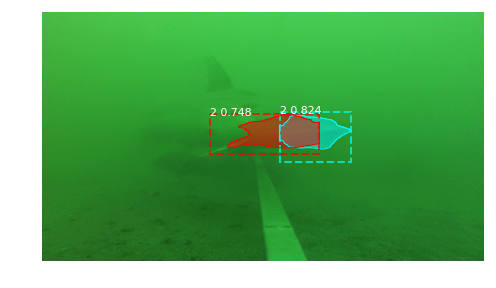

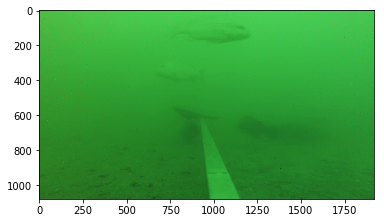

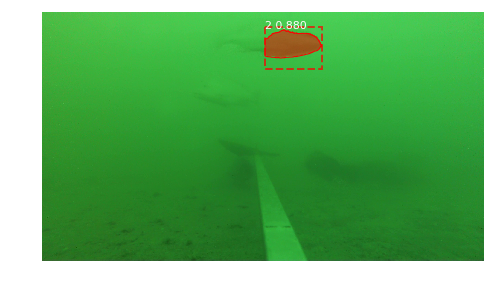

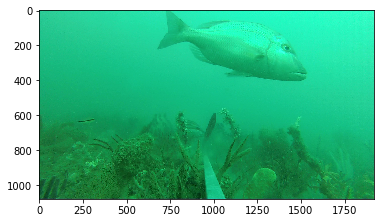

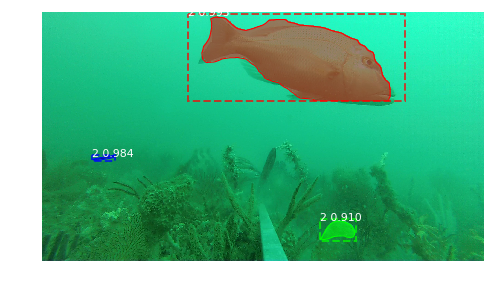

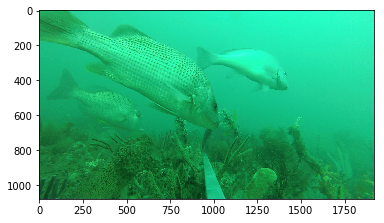

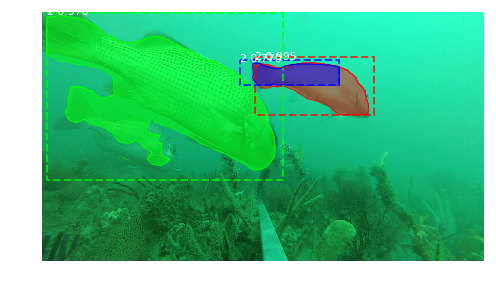

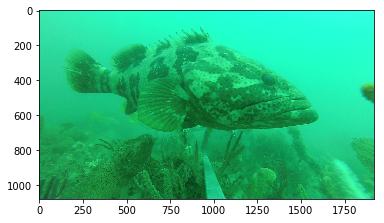

In [ ]:
test_set = glob.glob(os.path.join('frames' , 'test', '*.jpg'))

for test in test_set:
    try:
        original_image = plt.imread(test)
        plt.imshow(original_image)
        plt.show()
        results = model.detect([original_image])

        r = results[0]
        visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'], ax=get_ax())
    except IndexError as index_error:
        print(index_error)

### Evaluation

In [17]:
class InferenceConfig(ModelConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

inference_config = InferenceConfig()

### Calculate Mean Average Precision (mAP)

In [18]:
def display_images(images, titles=None, cols=4, cmap=None, norm=None,
                   interpolation=None):
    """Display the given set of images, optionally with titles.
    images: list or array of image tensors in HWC format.
    titles: optional. A list of titles to display with each image.
    cols: number of images per row
    cmap: Optional. Color map to use. For example, "Blues".
    norm: Optional. A Normalize instance to map values to colors.
    interpolation: Optional. Image interporlation to use for display.
    """
    titles = titles if titles is not None else [""] * len(images)
    rows = len(images) // cols + 1
    plt.figure(figsize=(14, 14 * rows // cols))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.title(title, fontsize=9)
        plt.axis('off')
        plt.imshow(image.astype(np.uint8), cmap=cmap,
                   norm=norm, interpolation=interpolation)
        i += 1
    plt.show()

In [19]:
def display_top_masks(image, mask, class_ids, class_names, limit=1):
    """Display the given image and the top few class masks."""
    to_display = []
    titles = []
    to_display.append(image)
    titles.append("H x W={}x{}".format(image.shape[0], image.shape[1]))
    # Pick top prominent classes in this image
    unique_class_ids = np.unique(class_ids)
    mask_area = [np.sum(mask[:, :, np.where(class_ids == i)[0]])
                 for i in unique_class_ids]
    top_ids = [v[0] for v in sorted(zip(unique_class_ids, mask_area),
                                    key=lambda r: r[1], reverse=True) if v[1] > 0]
    # Generate images and titles
    for i in range(limit):
        class_id = top_ids[i] if i < len(top_ids) else -1
        # Pull masks of instances belonging to the same class.
        m = mask[:, :, np.where(class_ids == class_id)[0]]
        m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1)
        to_display.append(m)
        titles.append(class_names[class_id] if class_id != -1 else "-")
    display_images(to_display, titles=titles, cols=limit + 1, cmap="Blues_r")

In [20]:
# Compute VOC-style mAP @ IoU=0.5

image_ids = np.random.choice(dataset_validate.image_ids, int(len(dataset_validate.image_ids) * 0.25))

APs = []

for image_id in image_ids:
    try:
        image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_validate, inference_config, image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)

        results = model.detect([image])

        r = results[0]

        # Compute AP
        AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        APs.append(AP)
        
        if AP < 0.5:
            print('AP:', AP)
            try:
                mask, class_ids = dataset_validate.load_mask(image_id)
                display_top_masks(image, mask, class_ids, dataset_validate.class_names)
            except AttributeError as attribute_error:
                print(attribute_error)
    except IndexError as index_error:
        pass
    
print("mAP: ", np.mean(APs))

mAP:  nan


/anaconda/envs/E3Hack-SvB/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda/envs/E3Hack-SvB/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Save Weights

In [ ]:
print(model.checkpoint_path)
print(model.model_dir)
print(model.log_dir)

upload_files(path=model.log_dir, share_folder=model_weights_share, overwrite=False)